### Deep Kung-Fu with advantage actor-critic

In this notebook you'll build a deep reinforcement learning agent for atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/) and train it with advantage actor-critic.

![http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg](http://www.retroland.com/wp-content/uploads/2011/07/King-Fu-Master.jpg)

In [0]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
"""Auxilary files for those who wanted to solve breakout with CEM or policy gradient"""
import numpy as np
import gym
from scipy.misc import imresize
from gym.core import Wrapper
from gym.spaces.box import Box

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1,):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward * self.reward_scale, done, info
    
    ### image processing ###
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = imresize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img


For starters, let's take a look at the game itself:
* Image resized to 42x42 and grayscale to run faster
* Rewards divided by 100 'cuz they are all divisible by 100
* Agent sees last 4 frames of game to account for object velocity

In [27]:
import gym
#from atari_util import PreprocessAtari

# We scale rewards to avoid exploding gradients during optimization.
reward_scale = 0.01

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4,
        reward_scale=reward_scale)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


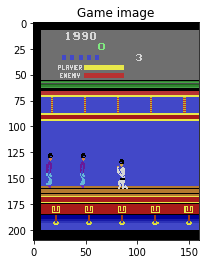

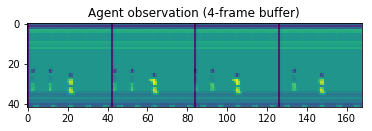

In [28]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

### Build an agent

We now have to build an agent for actor-critic training - a convolutional neural network that converts states into action probabilities $\pi$ and state values $V$.

Your assignment here is to build and apply a neural network - with any framework you want. 

For starters, we want you to implement this architecture:
![https://s17.postimg.org/orswlfzcv/nnet_arch.png](https://s17.postimg.org/orswlfzcv/nnet_arch.png)

After your agent gets mean reward above 50, we encourage you to experiment with model architecture to score even better.

In [29]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
from keras.layers import Conv2D, Dense, Flatten, Input
from keras.models import Model

class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
                        
            # Prepare neural network architecture
            ### Your code here: prepare any necessary layers, variables, etc.
            main_input=Input(shape=state_shape,dtype='float32')
            x=Conv2D(32,(3,3),strides=2,activation='elu')(main_input)
            x=Conv2D(32,(3,3),strides=2,activation='elu')(x)
            x=Conv2D(32,(3,3),strides=2,activation='elu')(x)
            x=Flatten()(x)
            x=Dense(128,activation='elu')(x)
            
            q=Dense(n_actions,activation='linear')(x)
            v=Dense(1,activation='linear')(x)
            self.network=Model(inputs=main_input,outputs=[q,v])
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)    
            
            
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        ### Your code here: apply agent's neural network to get policy logits and state values.
        
        logits = self.network(state_t)[0]#<logits go here>
        state_value = self.network(state_t)[1][:,0]#<state values go here>
        
        assert tf.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # hint: if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [0]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

In [32]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.03342284  0.0763776  -0.01562774  0.16604087  0.00513499  0.02452267
  -0.06931237  0.04399427  0.11878377  0.07618974 -0.23326367  0.08757861
   0.0749776  -0.01572585]]
state values:
 [-0.13385284]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


### Let's play!
Let's build a function that measures agent's average reward.

In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break

        # We rescale the reward back to ensure compatibility
        # with other evaluations.
        game_rewards.append(total_reward / reward_scale)
    return game_rewards

In [34]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[300.0, 300.0, 1800.0]


In [35]:
#show video
import os

from IPython.display import HTML

video_names = [s for s in os.listdir("./kungfu_videos/") if s.endswith(".mp4")]

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/" + video_names[-1]))  #this may or may not be _last_ video. Try other indices

### Training on parallel games
![img](https://s7.postimg.org/4y36s2b2z/env_pool.png)

To make actor-critic training more stable, we shall play several games in parallel. This means ya'll have to initialize several parallel gym envs, send agent's actions there and .reset() each env if it becomes terminated. To minimize learner brain damage, we've taken care of them for ya - just make sure you read it before you use it.


In [0]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

__Let's try it out:__

In [37]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State shape: (10, 42, 42, 4)
Actions: [2 5 2]
Rewards: [0. 0. 0.]
Done: [False False False]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


# Actor-critic

Here we define a loss functions and learning algorithms as usual.

In [0]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [0]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [0]:


# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph+gamma*next_state_values-state_values#<YOUR CODE>

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# compute policy entropy given logits_seq. Mind the "-" sign!
entropy = -tf.reduce_mean(probs*logprobs,axis=-1)#<YOUR CODE>

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "



actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values#<YOUR CODE>

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

In [41]:
# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

Entropy is too low for untrained agent
You just might be fine!


# Train 

Just the usual - play a bit, compute loss, follow the graidents, repeat a few million times.
![img](http://images6.fanpop.com/image/photos/38900000/Daniel-san-training-the-karate-kid-38947361-499-288.gif)

In [42]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
ewma = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


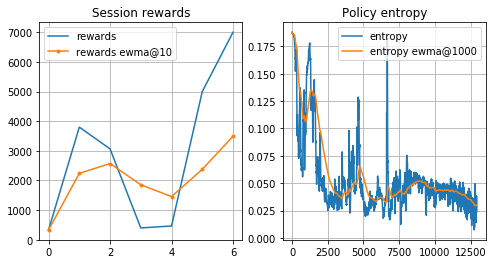




 95%|█████████▌| 9504/10000 [04:27<00:24, 20.44it/s]


 95%|█████████▌| 9509/10000 [04:27<00:20, 24.44it/s]


 95%|█████████▌| 9514/10000 [04:28<00:17, 28.44it/s]


 95%|█████████▌| 9519/10000 [04:28<00:15, 31.93it/s]


 95%|█████████▌| 9524/10000 [04:28<00:13, 35.16it/s]


 95%|█████████▌| 9529/10000 [04:28<00:12, 37.90it/s]


 95%|█████████▌| 9534/10000 [04:28<00:11, 39.92it/s]


 95%|█████████▌| 9539/10000 [04:28<00:11, 41.50it/s]


 95%|█████████▌| 9544/10000 [04:28<00:10, 42.23it/s]


 95%|█████████▌| 9549/10000 [04:28<00:10, 43.26it/s]


 96%|█████████▌| 9554/10000 [04:28<00:10, 44.21it/s]


 96%|█████████▌| 9559/10000 [04:28<00:09, 44.59it/s]


 96%|█████████▌| 9564/10000 [04:29<00:09, 44.74it/s]


 96%|█████████▌| 9569/10000 [04:29<00:09, 45.02it/s]


 96%|█████████▌| 9574/10000 [04:29<00:09, 44.77it/s]


 96%|█████████▌| 9579/10000 [04:29<00:09, 44.93it/s]


 96%|█████████▌| 9584/10000 [04:29<00:09, 45.32it/s]


 96%|█████████▌| 9589/10000 [04:29<00:09, 44.63it/s]


 96%|██

In [52]:
for i in trange(20000):
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states

    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0:
        if i % 2500 == 0:
            rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")# % color)

        clear_output(True)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards")
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(ewma(np.array(entropy_history), span=1000), label='entropy ewma@1000')
        plt.title("Policy entropy")
        plt.grid()
        plt.legend()
        plt.show()

Relax and grab some refreshments while your agent is locked in an infinite loop of violence and death.

__How to interpret plots:__

The session reward is the easy thing: it should in general go up over time, but it's okay if it fluctuates ~~like crazy~~. It's also OK if it reward doesn't increase substantially before some 10k initial steps. However, if reward reaches zero and doesn't seem to get up over 2-3 evaluations, there's something wrong happening.


Since we use a policy-based method, we also keep track of __policy entropy__ - the same one you used as a regularizer. The only important thing about it is that your entropy shouldn't drop too low (`< 0.1`) before your agent gets the yellow belt. Or at least it can drop there, but _it shouldn't stay there for long_.

If it does, the culprit is likely:
* Some bug in entropy computation. Remember that it is $ - \sum p(a_i) \cdot log p(a_i) $
* Your agent architecture converges too fast. Increase entropy coefficient in actor loss. 
* Gradient explosion - just [clip gradients](https://stackoverflow.com/a/43486487) and maybe use a smaller network
* Us. Or TF developers. Or aliens. Or lizardfolk. Contact us on forums before it's too late!

If you're debugging, just run `logits, values = agent.step(batch_states)` and manually look into logits and values. This will reveal the problem 9 times out of 10: you'll likely see some NaNs or insanely large numbers or zeros. Try to catch the moment when this happens for the first time and investigate from there.

### "Final" evaluation

In [45]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./kungfu_videos/")))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Final mean reward: 4880.0


In [46]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) 

In [47]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/" + video_names[-2]))  # try other indices

In [0]:
# if you don't see videos, just navigate to ./kungfu_videos and download .mp4 files from there.

In [0]:
import re
import requests
import json


class Grader(object):
    def __init__(self, assignment_key, all_parts=()):
        """
        Assignment key is the way to tell Coursera which problem is being submitted.
        """
        self.submission_page = \
            'https://www.coursera.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = assignment_key
        self.answers = {part: None for part in all_parts}

    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key,
                    "submitterEmail": email,
                    "secret": token,
                    "parts": {}
        }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)

    def set_answer(self, part, answer):
        """Adds an answer for submission. Answer is expected either as string, number, or
           an iterable of numbers.
           Args:
              part - str, assignment part id
              answer - answer to submit. If non iterable, appends repr(answer). If string,
                is appended as provided. If an iterable and not string, converted to
                space-delimited repr() of members.
        """
        if isinstance(answer, str):
            self.answers[part] = answer
        else:
            try:
                self.answers[part] = " ".join(map(repr, answer))
            except TypeError:
                self.answers[part] = repr(answer)


def array_to_grader(array, epsilon=1e-4):
    """Utility function to help preparing Coursera grading conditions descriptions.
    Args:
       array: iterable of numbers, the correct answers
       epslion: the generated expression will accept the answers with this absolute difference with
         provided values
    Returns:
       String. A Coursera grader expression that checks whether the user submission is in
         (array - epsilon, array + epsilon)"""
    res = []
    for element in array:
        if isinstance(element, int):
            res.append("[{0}, {0}]".format(element))
        else:
            res.append("({0}, {1})".format(element - epsilon, element + epsilon))
    return " ".join(res)

In [0]:
import sys
import numpy as np
sys.path.append("..")
#import grading


def submit_cartpole(generate_session, email, token):
    sessions = [generate_session() for _ in range(100)]
    session_rewards = np.array(sessions)
    grader = Grader("oyT3Bt7yEeeQvhJmhysb5g")
    grader.set_answer("7QKmA", int(np.mean(session_rewards)))
    grader.submit(email, token)


def submit_kungfu(agent, env, evaluate, email, token):
    sessions = [evaluate(agent=agent, env=env, n_games=1) for _ in range(100)]
    session_rewards = np.array(sessions)
    grader = Grader("6sPnVCn6EeieSRL7rCBNJA")
    grader.set_answer("HhNVX", int(np.mean(session_rewards)))
    grader.submit(email, token)


In [53]:
#from submit import submit_kungfu
env = make_env()
submit_kungfu(agent, env, evaluate, "ss.ghule@ncl.res.in", "HOakJoMaEaFLNL96")

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Submitted to Coursera platform. See results on assignment page!


```

```
```

```
```

```
```

```
```

```
```

```
```

```
```

```


### Now what?
Well, 5k reward is [just the beginning](https://www.buzzfeed.com/mattjayyoung/what-the-color-of-your-karate-belt-actually-means-lg3g). Can you get past 200? With recurrent neural network memory, chances are you can even beat 400!

* Try n-step advantage and "lambda"-advantage (aka GAE) - see [this article](https://arxiv.org/abs/1506.02438)
 * This change should improve early convergence a lot
* Try recurrent neural network 
 * RNN memory will slow things down initially, but in will reach better final reward at this game
* Implement asynchronuous version
 * Remember [A3C](https://arxiv.org/abs/1602.01783)? The first "A" stands for asynchronuous. It means there are several parallel actor-learners out there.
 * You can write custom code for synchronization, but we recommend using [redis](https://redis.io/)
   * You can store full parameter set in redis, along with any other metadate
   * Here's a _quick_ way to (de)serialize parameters for redis
   ```
   import joblib
   from six import BytesIO
```
```
   def dumps(data):
        "converts whatever to string"
        s = BytesIO()
        joblib.dump(data,s)
        return s.getvalue()
``` 
```
    def loads(string):
        "converts string to whatever was dumps'ed in it"
        return joblib.load(BytesIO(string))
```